## Statistical Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn import learning_curve
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
import seaborn as sns #statistics data visualization
#sns.set_style('whitegrid')
from sklearn.ensemble import VotingClassifier
%matplotlib inline

In [2]:
df= pd.read_csv('data.csv')

### CountPlot

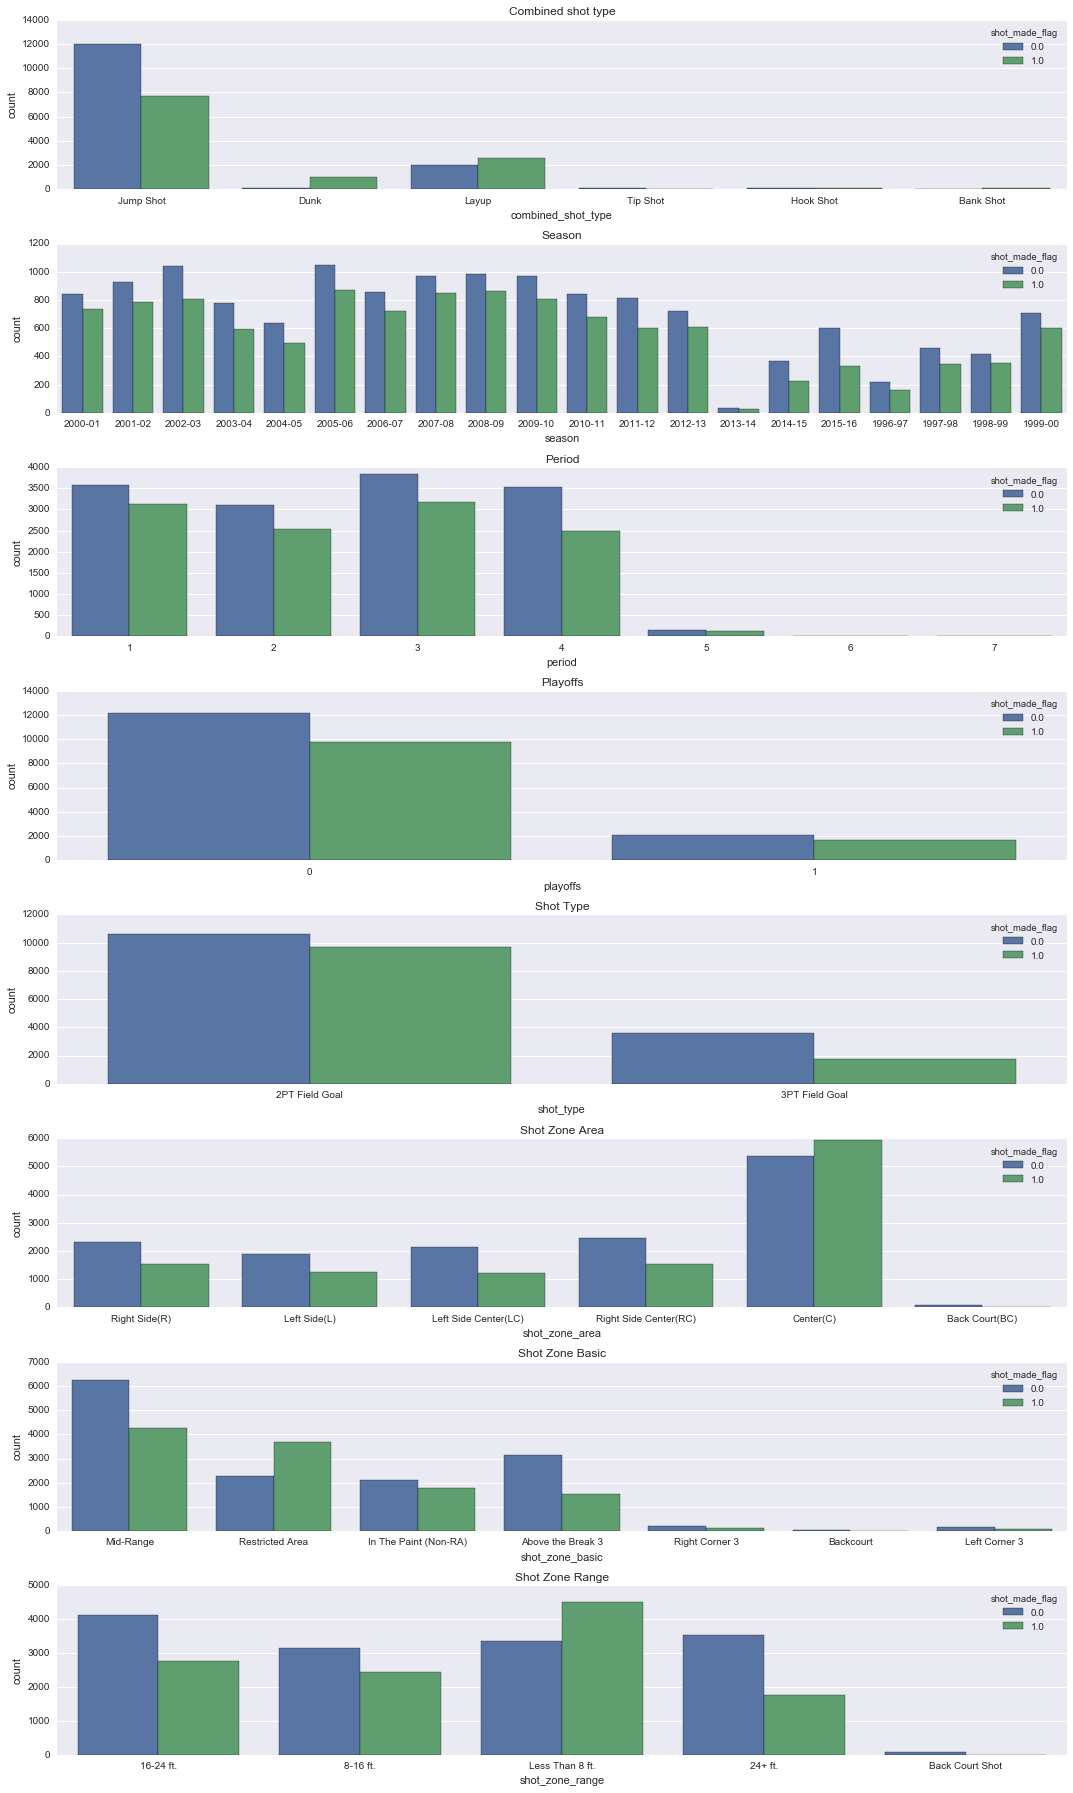

In [3]:
f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=df, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=df, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=df, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=df, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=df, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=df, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=df, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=df, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

plt.tight_layout()
plt.show()

### Correlation Matrix

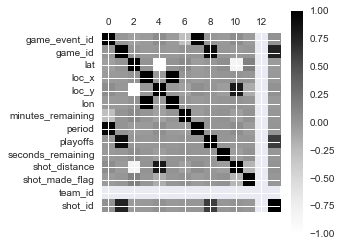

In [4]:
df.corr()
plt.matshow(df.corr())
plt.yticks(range(len(df.corr().columns)), df.corr().columns); 
plt.colorbar()
plt.show()

In [ ]:
def detect_outliers(series, whis=1.5):
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25
    return ~((series - series.median()).abs() <= (whis * iqr))

df['outliers_distance'] = detect_outliers(df['shot_distance'])
df=df[df['outliers_distance'] == False]
df=df.drop('outliers_distance', axis = 1)

### Preparing Data

In [5]:
target = df['shot_made_flag'].copy()
nildata = df['shot_made_flag'].isnull()

### Feature Engineering

In [6]:
df['6secondes_remaining'] = df['seconds_remaining'] < 6
df['home_play'] = df['matchup'].str.contains('vs').astype('int')
df['game_date'] = pd.to_datetime(df['game_date'])
df['game_year'] = df['game_date'].dt.year

In [7]:
df=df.drop(labels=['team_name', 'opponent', 'shot_id', 
                   'game_date', 'team_id','matchup','game_event_id','game_id',
                   'minutes_remaining', 'lat','lon','shot_made_flag','seconds_remaining'], axis=1)

### Transforming categorical columns

In [8]:
categorial_cols = [
    'action_type', 'period', 'season', 'combined_shot_type','shot_type', 'game_year',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',  'loc_x', 'loc_y']

for cc in categorial_cols: ##create bin for categorical columns
    dummies = pd.get_dummies(df[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    df.drop(cc, axis = 1, inplace = True)
    df = df.join(dummies)

### Final Dataset

In [10]:
X = df[~nildata]
test = df[nildata]
Y = target[~nildata]

## Machine Learning

In [ ]:
num_trees = 100
model = RandomForestClassifier(n_estimators=50,oob_score=True)

results = cross_val_score(model, X, Y)
print(results.mean(),'+/-', results.std())

In [ ]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, max_features=15, warm_start=True)

results = cross_val_score(model, X, Y)
print(results.mean(),'+/-', results.std())

In [ ]:
model = LogisticRegression(penalty='l2', C=1)

results = cross_val_score(model, X, Y)
print(results.mean(),'+/-', results.std())

In [ ]:
# Create sub models
estimators = []

estimators.append(('lr', LogisticRegression(penalty='l2', C=1)))
estimators.append(('gbm', GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, max_features=15, warm_start=True)))
estimators.append(('rf', RandomForestClassifier(n_estimators=50,oob_score=True)))


# create the ensemble model
ensemble = VotingClassifier(estimators, voting='soft')

results = cross_val_score(ensemble, X, Y)
print(results.mean(),'+/-', results.std())

In [ ]:
ensemble.fit(X, Y)
preds = ensemble.predict_proba(test)

submission = pd.DataFrame()
submission["shot_id"] = test.index
submission["shot_id"]=submission["shot_id"]+1
submission["shot_made_flag"]= preds[:,0]

submission.to_csv("sub.csv",index=False)